# Generate the images with Principal Component Analysis

### Imports

In [1]:
import sys
sys.path.append('../')

import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.decomposition import PCA
from scipy.interpolate import interp1d

from training.generator import Generator
from training import utils
from training.settings import *

utils.reset_rand()

### Check GPU

In [2]:
utils.check_gpu()

1 GPU is available! Using GPU: "NVIDIA GeForce RTX 3090" (22.77 GB available)


### Import the model

In [3]:
MODEL_PATH = 'output/last_model'

model = Generator().to(DEVICE)
model.load_state_dict(torch.load(os.path.join('..', MODEL_PATH, 'ma_generator.pt')))

<All keys matched successfully>

### Mean W image

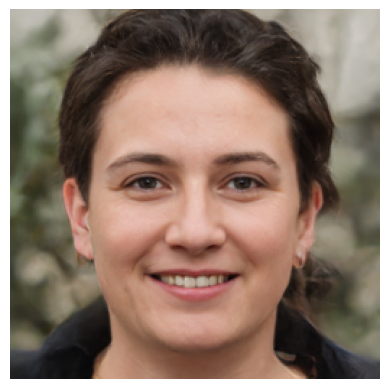

In [4]:
image = model.generate_one(0.0)

plt.imshow(image)
plt.axis('off')
plt.show()

### Settings

### PCA

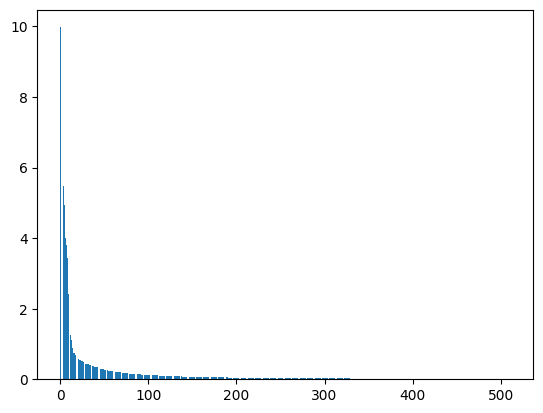

In [5]:
ws = model.gen_w(100_000).detach().to('cpu').numpy()

mean_ws = np.mean(ws, axis = 0)
std_ws = np.std(ws, axis = 0)

ws = (ws - mean_ws[None, :]) / std_ws[None, :]

pca = PCA(n_components = LATENT_DIM)
pca.fit(ws)

eigen_values = pca.explained_variance_
eigen_vectors = pca.components_

_ = plt.bar(np.arange(len(eigen_values)), 100 * eigen_values / np.sum(eigen_values))

In [6]:
def to_pca_space(w):
	return pca.transform((w - mean_ws[None, :]) / std_ws[None, :])

def to_unit_space(w):
	return pca.inverse_transform(w) * std_ws[None, :] + mean_ws[None, :]

ws_pca = to_pca_space(ws)
ws_pca_mean = np.mean(ws_pca, axis = 0)
ws_pca_std = np.std(ws_pca, axis = 0)

def get_pca_component(w, index):
	w_pca = to_pca_space(w.detach().to('cpu').numpy())
	return (w_pca[:, index] - ws_pca_mean[index]) / ws_pca_std[index]

def set_pca_component(w, index, value):
	w_pca = to_pca_space(w.detach().to('cpu').numpy())
	w_pca[:, index] = ws_pca_mean[index] + value * ws_pca_std[index]
	return torch.as_tensor(to_unit_space(w_pca), dtype = torch.float32, device = DEVICE)

In [59]:
nb_w = 10
w = model.gen_w(nb_w)

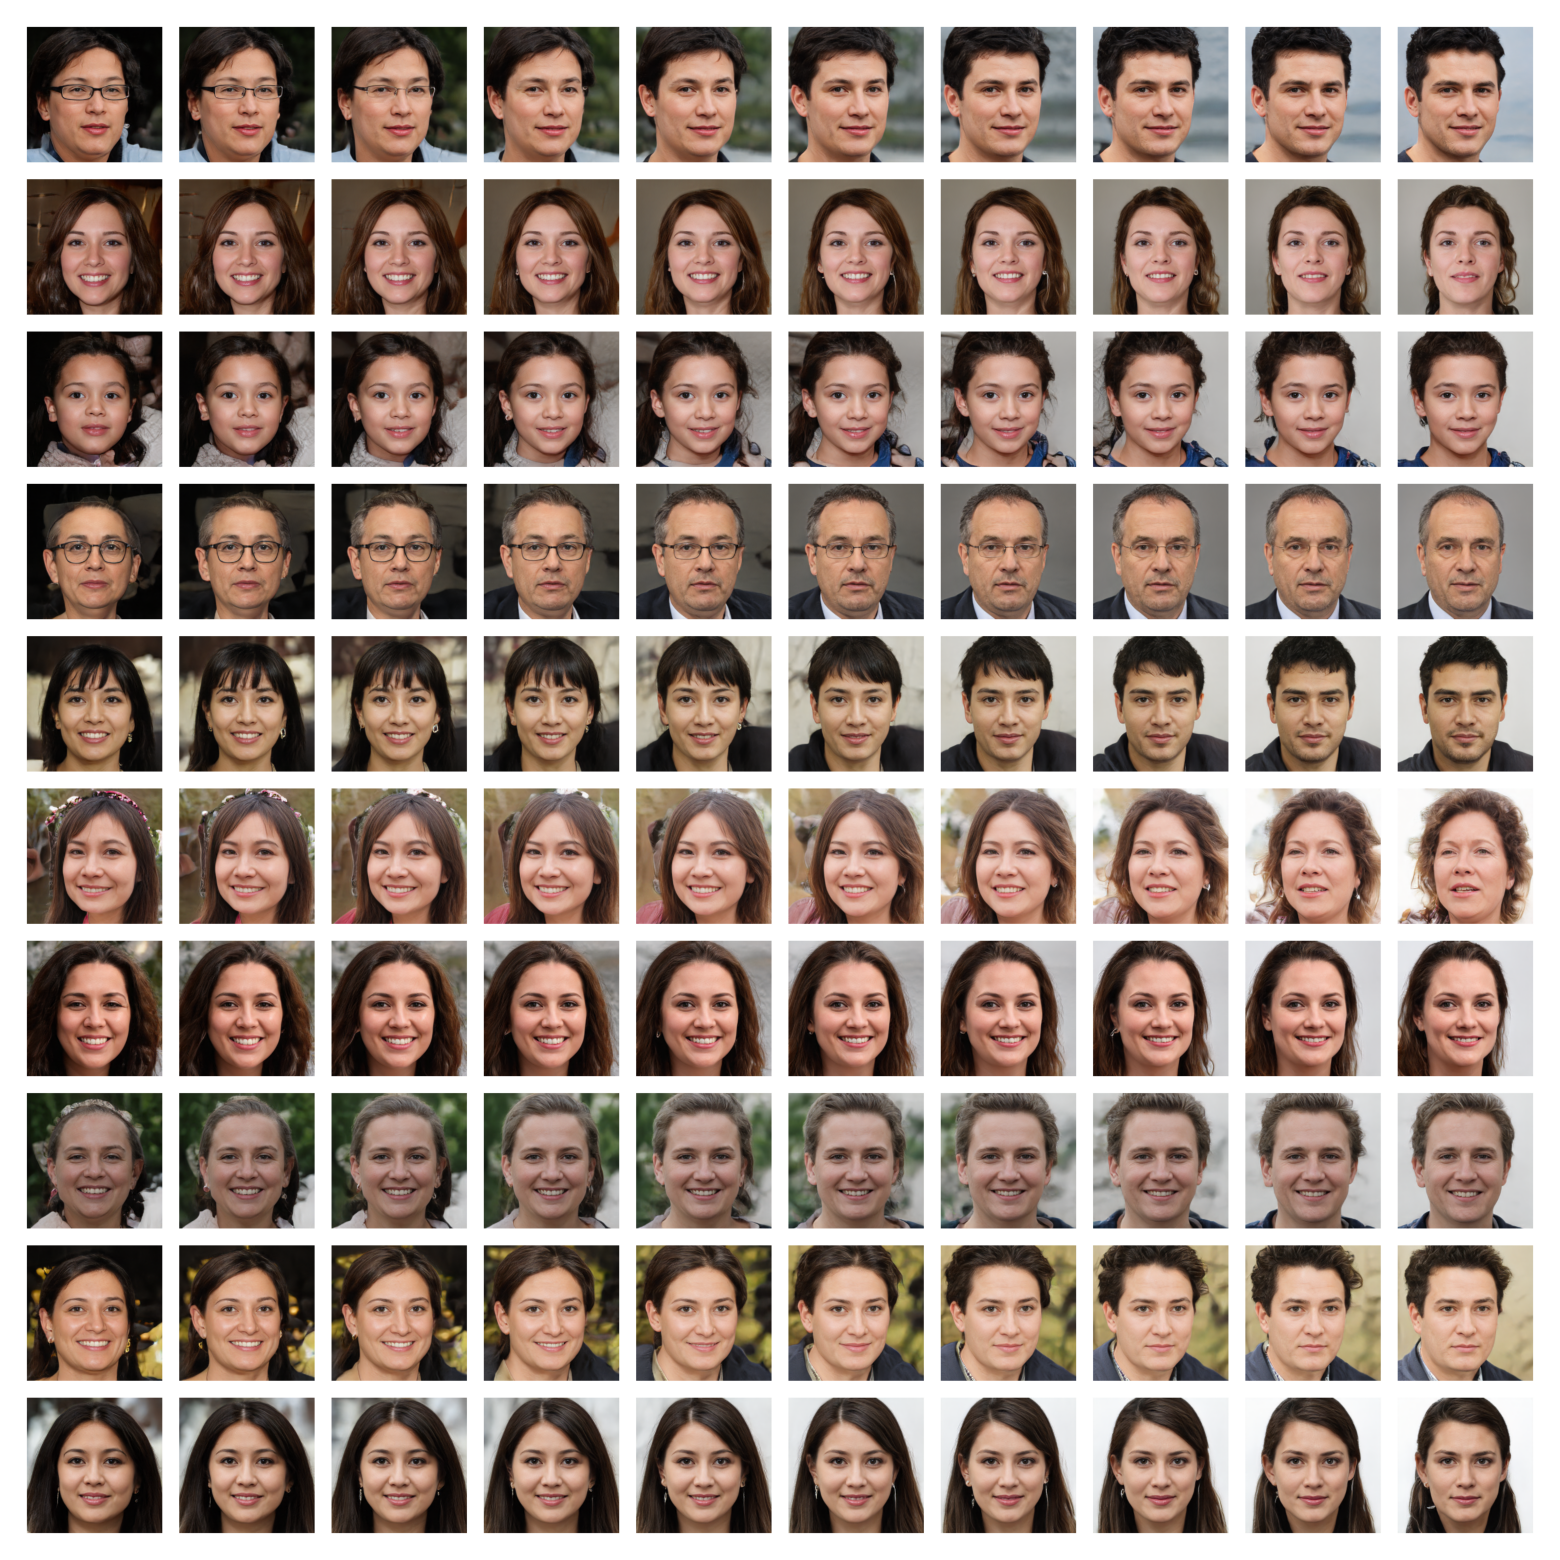

In [61]:
nb = 10
component = 0
# 0: background brightness
# 1: hat
# 2: x position (right to left)
# 3: age

cat_w = None

for i in np.linspace(-2, 2, nb, endpoint = True):

	test = set_pca_component(w, component, i)

	if cat_w is None:
		cat_w = test
	else:
		cat_w = torch.cat([cat_w, test], dim = 0)

cat_w = cat_w.reshape((nb_w, nb, LATENT_DIM))
cat_w = cat_w.transpose(0, 1)
cat_w = cat_w.reshape((-1, LATENT_DIM))

images = model.w_to_images(cat_w, psi = 0.5)
images = utils.create_grid(images, (nb, 1))

Image.fromarray(images).save('../test.png')

plt.figure(figsize = (20, 20))
plt.imshow(images)
plt.axis('off')
plt.show()